In [2]:
import numpy as np
import pandas as pd
import datetime
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import matplotlib.pyplot as plt
%matplotlib inline
train = pd.read_csv('dataset/sales_train.csv')
test = pd.read_csv('dataset/test.csv')
shops = pd.read_csv('dataset/shops.csv')
items = pd.read_csv('dataset/items.csv')
items_categories = pd.read_csv('dataset/item_categories.csv')
submission = pd.read_csv('dataset/sample_submission.csv')

In [3]:
def preprocess_date(data):
    data.date = data.date.apply(lambda x : datetime.datetime.strptime(x, '%d.%m.%Y'))
    return data

# test if functions work
train = preprocess_date(train)
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [4]:
def groupby_dbn_shopid_item(data):
    month_sales = data.groupby(["date_block_num","shop_id","item_id"])["date","item_price","item_cnt_day"].agg({"date":["min","max"], "item_price":"mean", "item_cnt_day":"sum"})
    return month_sales

def create_timeseries(data):
    ts = data.groupby(["date_block_num"])["item_cnt_day"].sum()
    ts.astype('float')
    return ts

def create_revenue(data):
    data["revenue"] = data["item_cnt_day"] * data["item_price"]
    return data

def create_item_cnt_month(data):
    group = data.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
    group.columns = ['item_cnt_month']
    group.reset_index(inplace=True)
    return group

date_block_num
0     131479.0
1     128090.0
2     147142.0
3     107190.0
4     106970.0
5     125381.0
6     116966.0
7     125291.0
8     133332.0
9     127541.0
10    130009.0
11    183342.0
12    116899.0
13    109687.0
14    115297.0
15     96556.0
16     97790.0
17     97429.0
18     91280.0
19    102721.0
20     99208.0
21    107422.0
22    117845.0
23    168755.0
24    110971.0
25     84198.0
26     82014.0
27     77827.0
28     72295.0
29     64114.0
30     63187.0
31     66079.0
32     72843.0
33     71056.0
Name: item_cnt_day, dtype: float64


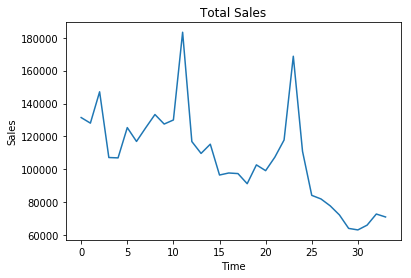

In [12]:
ts = create_timeseries(train)
plt.title("Total Sales")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.plot(ts)
plt.show()

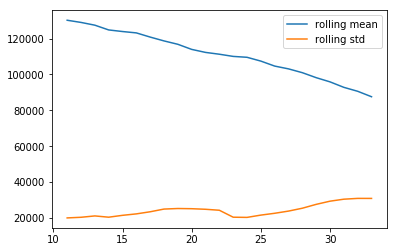

In [13]:
plt.plot(ts.rolling(window=12,center=False).mean(), label="rolling mean")
plt.plot(ts.rolling(window=12,center=False).std(), label="rolling std")
plt.legend()
plt.show()

In [14]:
# test stationarity 
def test_stationarity(ts):
    adf = adfuller(ts, autolag = "AIC")
    adfoutput = pd.Series(adf[0:4], index = ["Test Statistic", "p-value", "# of lags used", "Number of Obversation"])
    for key, value in adf[4].items():
        adfoutput["critical value (" + key + ")"] = value
    print(adfoutput)
test_stationarity(ts)

Test Statistic           -2.395704
p-value                   0.142953
# of lags used            0.000000
Number of Obversation    33.000000
critical value (1%)      -3.646135
critical value (5%)      -2.954127
critical value (10%)     -2.615968
dtype: float64


In [15]:
# Create differenced series
def difference(data, interval = 1):
    diff = []
    for i in range(interval, len(data)):
        val = data[i] - data[i - interval]
        diff.append(val)
    return pd.Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, val):
    return val + last_ob

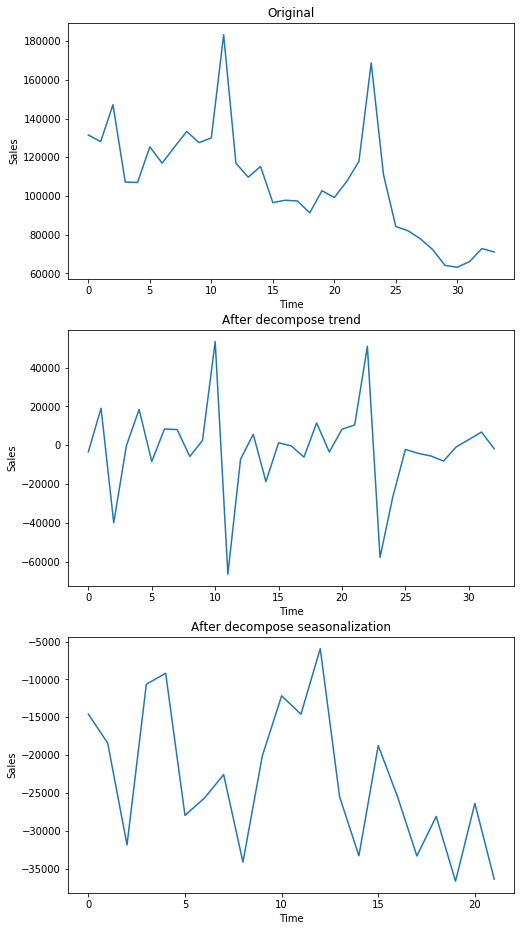

In [16]:
ts = create_timeseries(train)
plt.figure(figsize=(8, 16))
plt.subplot(311)
plt.title("Original")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.plot(ts)

plt.subplot(312)
plt.title("After decompose trend")
plt.xlabel("Time")
plt.ylabel("Sales")
detrend_ts = difference(ts)
plt.plot(detrend_ts)
plt.plot()

plt.subplot(313)
plt.title("After decompose seasonalization")
plt.xlabel("Time")
plt.ylabel("Sales")
deseason_ts = difference(ts, 12)
plt.plot(deseason_ts)
plt.plot()
plt.show()

In [17]:
test_stationarity(deseason_ts)

Test Statistic           -3.270101
p-value                   0.016269
# of lags used            0.000000
Number of Obversation    21.000000
critical value (1%)      -3.788386
critical value (5%)      -3.013098
critical value (10%)     -2.646397
dtype: float64


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4791      7.576     -0.063      0.950     -15.328      14.370
ma.L1          0.4769      7.502      0.064      0.949     -14.226      15.180
ma.L2          0.0505      1.411      0.036      0.971      -2.715       2.816
ar.S.L12       0.7545      0.589      1.282      0.200      -0.399       1.908
sigma2      5.273e+08   4.73e-09   1.12e+17      0.000    5.27e+08    5.27e+08


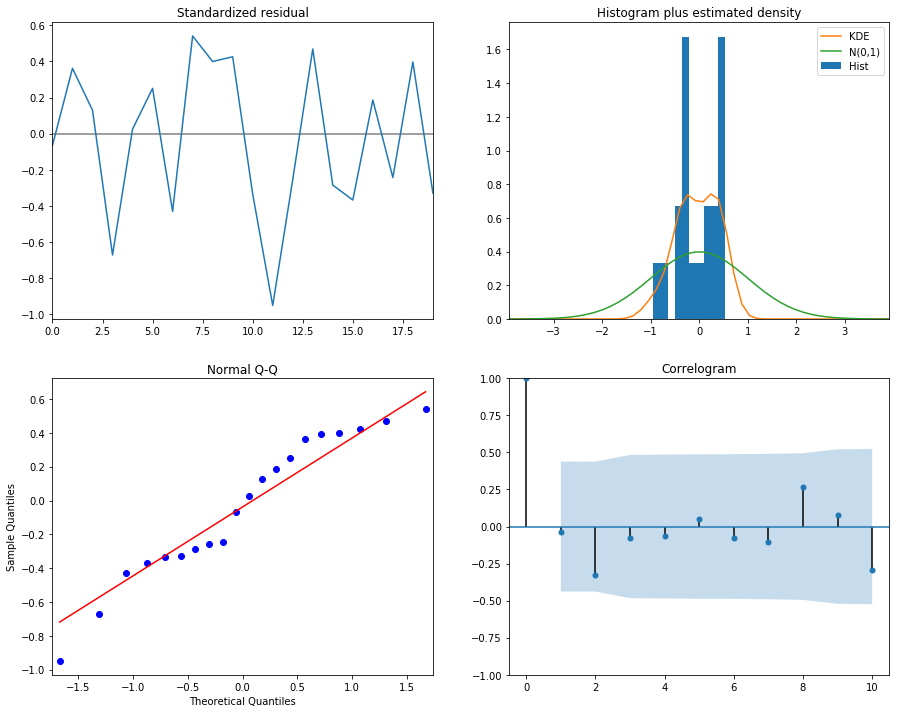

[ 79610.6568924  117309.03708527  74054.0285998   53691.56393718
  52122.05115706]


In [25]:
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def arima_predict(data):
    mod = sm.tsa.statespace.SARIMAX(data,
                                    order=(1, 1, 2),
                                    seasonal_order=(1, 0, 0, 12),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()
    print(results.summary().tables[1])
    results.plot_diagnostics(figsize=(15, 12))
    plt.show()
    
    pred = results.get_prediction(10, dynamic=False)
    pred_ci = pred.conf_int()
    #print(pred_ci.shape)
    print((results.forecast(5)))
    return 

arima_predict(ts.tolist())

In [130]:
train = pd.merge(train, items, on="item_id")
train = pd.merge(train, items_categories, on="item_category_id")
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name
0,2013-01-02,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,2013-01-23,0,24,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
2,2013-01-20,0,27,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
3,2013-01-02,0,25,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
4,2013-01-03,0,25,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray


In [131]:
sales_by_category = train.groupby("item_category_name", as_index = False)["item_price"].sum().sort_values(by = "item_price")

In [132]:
from googletrans import Translator
translator = Translator()
i = 0
for row in sales_by_category["item_category_name"]:
    english_word = translator.translate(row)
    sales_by_category.iloc[i,0] = english_word.text
    i+=1

In [136]:
sales_by_category.iloc[3,0] = "Books - Travel Guides"
sales_by_category.head(n = 80)

,item_category_name,item_price
50,Books - Postcards,4.100000e+01
51,Books - Cognitive Literature,1.290000e+02
0,PC - Headsets / Headphones,2.634000e+02
52,Books - Travel Guides,3.000000e+02
1,Accessories - PS2,4.310000e+02
53,Books - Fiction,8.470000e+02
48,Books - Computer Literature,1.654000e+03
10,Game Consoles - PS2,1.998000e+03
18,Games - PS2,3.828200e+03
46,Books - Business Literature,4.502000e+03


In [138]:
sales_by_category["item_category"] = sales_by_category.item_category_name.str.extract('([A-Za-z\ ]+)', expand=False) 
sales_by_category.head()

,item_category_name,item_price,item_category
50,Books - Postcards,41.0,Books
51,Books - Cognitive Literature,129.0,Books
0,PC - Headsets / Headphones,263.4,PC
52,Books - Travel Guides,300.0,Books
1,Accessories - PS2,431.0,Accessories


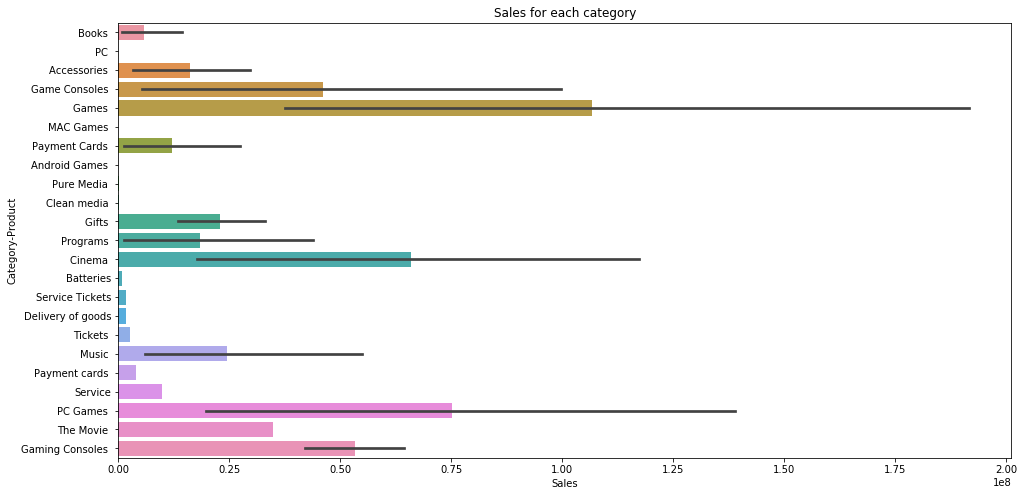

In [143]:
import seaborn as sns
plt.figure(figsize = (16,8))
sns.barplot(y = "item_category", x = "item_price", data = sales_by_category)
plt.title("Sales for each category")
plt.xlabel("Sales")
plt.ylabel("Category-Product")
plt.show()

In [145]:
train_translation = train.groupby(["item_category_id"])["date","item_price","item_cnt_day"].agg({"date":["min","max"], "item_price":"mean", "item_cnt_day":"sum"})
i = 0
for row in train["item_category_name"]:
    if row == "":
        continue
    english_word = translator.translate(row)
    train.iloc[i,0] = english_word.text
    i+=1

JSONDecodeError: Expecting value: line 1 column 1 (char 0)